# Mapping synaptic activity in an infinite cable and layer 5 neuron to activity of an extended-like point neuron (S7)


In [1]:
from neuron import gui,h
import pandas as pd
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%pylab
%matplotlib inline

dend = h.Section(name="dend")


#Variables
dend.L = 9500 # at this length (&diam) the cable is basicaly infinite
dend.diam = 1.5
dend.nseg = 101
dend.insert("pas")
Rm = 10000.0

for sec in h.allsec():
    sec.g_pas = 1/Rm
    sec.cm =1 
    sec.Ra = 100

    
nstim = h.NetStim() #1 netstim to contorol synaptic activations

#create synapses across the neuron
dend_synapses = []
dend_ncons = []
for seg in dend:
    dend_syn = h.Exp2Syn(seg)
    dend_syn.tau1=0.0001#0.3
    dend_syn.tau2=9e9#10
    dend_syn.e = 0
    
    dend_synapses.append(dend_syn)
    
    ncon_dend = h.NetCon(nstim,dend_syn)
    ncon_dend.weight[0] = 0
    dend_ncons.append(ncon_dend)



nstim.number = 1
nstim.noise = 0
nstim.start = 40

vvec = h.Vector().record(dend(0.5)._ref_v)
tvec = h.Vector().record(h._ref_t)

iclamp = h.IClamp(dend(0.5))
seclamp = h.SEClamp(dend(0.5))
seclamp_current = h.Vector().record(seclamp._ref_i)

h.v_init = dend.e_pas


#check cell input resistance

imp = h.Impedance()
imp.loc(0.5,sec=dend)
imp.compute(0,1)
Rin = imp.input(0.5,sec=dend)


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


# Set parameters

In [2]:
h.tstop = nstim.start+100 + 300
iclamp.delay  = nstim.start+100
iclamp.dur = h.tstop + 10
cur_amp = 0.05 # nA
iclamp.amp = cur_amp #nA

# Check conductance change as a function of distance from center

In [8]:
for ncon in dend_ncons: ncon.weight[0] = 0 
# For now I'll just run on a range, but I'll need to do a better search in the future!
syn_conds = [0.0001]
numeric_dvs = []
g_syns = []
sample_v = []
dv_from_syn = []
dist_per_syn = []
seg_x = []
syn_weight = []
numeric_dvs_s = []
v_per_syn = {}
for ncon_dend in tqdm(dend_ncons):
    v_per_syn[ncon_dend.syn().get_segment()] = {}
    for syn_cond in syn_conds:
        ncon_dend.weight[0] =syn_cond
        g_syn = ncon_dend.weight[0]*10**3 #from micro to nano
        g_syns.append(g_syn)
        syn_weight.append(syn_cond)
        

        h.run()
        #plot(tvec,vvec)
        dv = vvec[-1]-vvec[int((iclamp.delay-10)/h.dt)]
        dv_from_syn.append(vvec[int((iclamp.delay-10)/h.dt)]-vvec[10])
        if syn_cond > 0.0000015 and sample_v==[]:
            sample_v = list(vvec)
            

        
        numeric_dvs.append(dv)
        seg_x.append(ncon_dend.syn().get_segment().x)
        ncon_dend.weight[0] = 0 
        
        v_per_syn[ncon_dend.syn().get_segment()][syn_cond] = np.array(vvec)
        dist_per_syn.append(h.distance(ncon_dend.syn().get_segment(),dend(0.5)))


In [9]:
df = pd.DataFrame({'numeric_dvs':numeric_dvs, 'g_syns':g_syns, 'dv_from_syn':dv_from_syn, 'syn_weight':syn_weight, 'seg_x':seg_x,'dist_per_syn':dist_per_syn})


# Calc rho and alpha

In [10]:
df = pd.DataFrame({'numeric_dvs':numeric_dvs, 'g_syns':g_syns, 'dv_from_syn':dv_from_syn, 'syn_weight':syn_weight, 'seg_x':seg_x,'dist_per_syn':dist_per_syn})

df['g_eff'] = None
df['alpha'] = None
df['rho'] = None
df['alpharho'] = None
plotting = False
for seg_x_to_show in list(set(df.seg_x)):


    #df_ncon = df.query("seg_x == @seg_x_to_show and dv_from_syn>@min_syn_dv and dv_from_syn<@max_syn_dv").sort_values('g_syns')
    df_ncon = df.query("seg_x == @seg_x_to_show").sort_values('g_syns')
    
    g_eff = 1/(df_ncon['numeric_dvs']/cur_amp)*10**3 #mv/nA ?=uS --*10**3--> nS ?
    if plotting:
        _,axes = subplots(ncols=4, sharex=True,figsize=(10,3))
        sca(axes[0])
        plot(df_ncon['g_syns'],g_eff,'-o')
        xlabel('gs (nS)')
        ylabel('g_eff (nS)')
    df.loc[df_ncon.index,'g_eff'] = g_eff

    ## calc ar ###
    ##############
    gl_S = 1/Rin*10**-6 # uS -> S
    cur_amp_A = cur_amp*10**-9 # nA
    dvs_V = df_ncon['numeric_dvs']*10**-3 # mV ->V
    g_syns_S = df_ncon['g_syns']*10**-9 #  nS ->S

    ar = ((cur_amp_A/dvs_V)-gl_S)/g_syns_S
    if plotting:
        sca(axes[1])
        plot(df_ncon['g_syns'],ar ,'-o')
        xlabel('gs (nS)')
        ylabel(r'$\alpha \rho$')
    
    df.loc[df_ncon.index,'alpharho'] = ar



    ## calc alpha ##
    ################
    dvs_fromsyn_V = df_ncon['dv_from_syn']*10**-3 # mV ->V
    g_eff_S = g_eff*10**-9
    V_diff = (dend.e_pas-dend_syn.e)*10**-3 #mV ->V
    g_syns_S


    a = -1*(dvs_fromsyn_V*g_eff_S)/(V_diff*g_syns_S)

    df.loc[df_ncon.index,'alpha'] = a
    
    if plotting:
        sca(axes[2])
        plot(df_ncon['g_syns'],a ,'-o')
        xlabel('gs (nS)')
        ylabel(r'$\alpha$')
        tight_layout()
    ## calc rho   ##
    ################


    df.loc[df_ncon.index,'rho'] = ar/a
    
    if plotting:
        sca(axes[3])
        plot(df_ncon['g_syns'],ar/a ,'-o')
        xlabel('gs (nS)')
        ylabel(r'$\rho$')
        tight_layout()
    

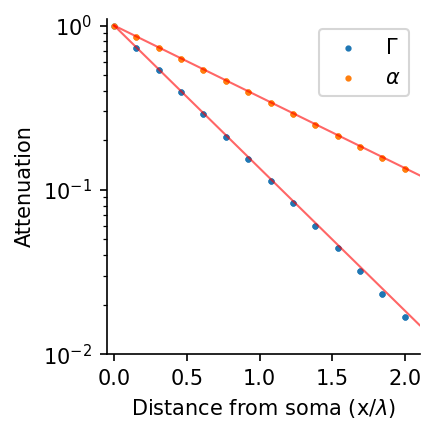

In [16]:
figure(figsize=(3,3),dpi=150)
lmda = sqrt(((dend(0.5).diam/2*10**-4)*Rm)/(2*dend.Ra))*10**4

scatter(df['dist_per_syn']/lmda,df['alpharho'],label='$\Gamma$',s=4)
scatter(df['dist_per_syn']/lmda,df['alpha'],label=r'$\alpha$',s=4)
plot(np.arange(0,2000)/lmda,exp(-np.arange(0,2000)/lmda),color='red',lw=1,alpha=0.6)
plot(np.arange(0,2000)/lmda,exp(-2*np.arange(0,2000)/lmda),color='red',lw=1,alpha=0.6)
xlabel(r'Distance from soma (x/$\lambda$)')
gca().set_yscale('log')
ylabel('Attenuation')
xlim(-0.05,2.1)
ylim(0.01,1.1)
sns.despine()
tight_layout()
legend()
#savefig(f'figs/fig_cable/cable_lambda_{lmda}.pdf')

In [26]:
iclamp.dur = 0

# Now let's build a single model-compartment model


In [27]:
single_comp = h.Section("single_com")
single_comp.insert("pas")

single_comp.g_pas =1/Rm
single_comp.cm = 1
single_comp.nseg = 1

In [28]:
single_comp.L=7.65
single_comp.diam = Rm/((Rin*10**6)*2*pi*single_comp.L*10**-6)*2*100 #<Calcualte diam so to get the same input resistance
single_comp.nseg=1
h.init()
imp = h.Impedance()
imp.loc(0.5,sec=single_comp)
imp.compute(0,1)
print(f"infinte cable- {Rin:,}")
Rin1 = imp.input(0.5,sec=single_comp)
print(f'Single Comp Rin - {Rin1:,}')

infinte cable- 172.757298093311
Single Comp Rin - 172.7572981366766


In [32]:

syn_cond = 0.1 # nS
synapses = df.dropna().copy()
synapses['g_syns'] = synapses['g_syns'].round(5)
synapses = synapses.query("g_syns == @syn_cond")

nstim_cc = h.NetStim()
nstim_cc.number = 1
nstim_cc.noise = 0
nstim_cc.start = 40

synape_per_x =  {}
ncon_per_x = {}
for _,row in synapses.iterrows():
    cc_syn = h.Exp2Syn_cc(single_comp(0.5))

    cc_syn.alpha = row['alpha']
    cc_syn.rho = row['rho']
    cc_syn.tau1=0.0001#0.3
    cc_syn.tau2=9e9#10
    cc_syn.e = 0
    cc_syn.e_pas = -70

    
    synape_per_x[row['seg_x']] = cc_syn
    
    cc_ncon = h.NetCon(nstim_cc,cc_syn)
    cc_ncon.weight[0] = 0
    ncon_per_x[row['seg_x']] = cc_ncon
    
    

In [33]:
singe_vv = h.Vector().record(single_comp(0.5)._ref_v)

# Show staedystate responses 

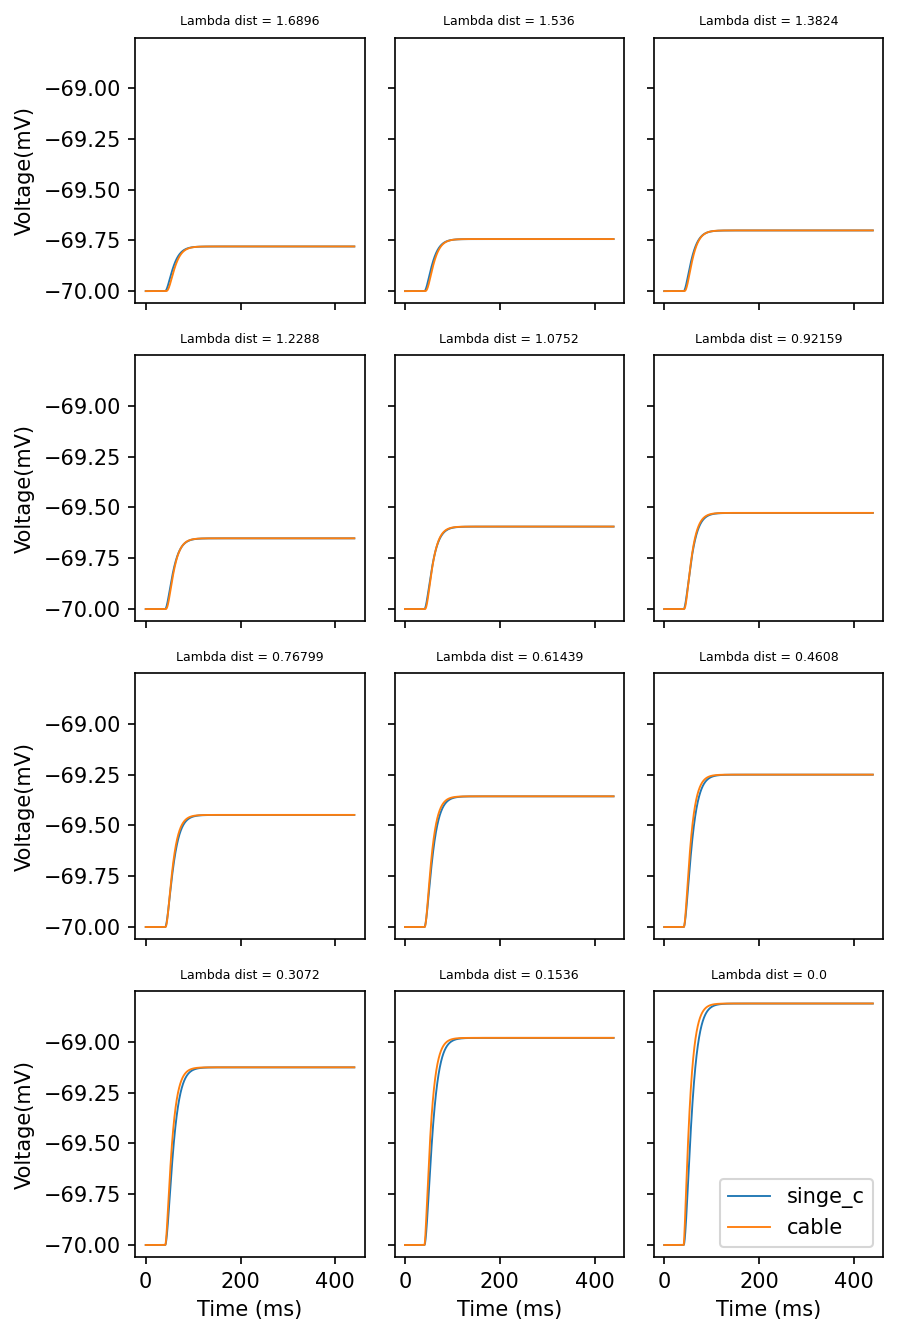

In [41]:
#rtime = 0.5 #ms
#dtime = 3.5 #ms
rtime=0.0001#0.3
dtime=9e9#10

for syn in synape_per_x.values():
    syn.tau1 = rtime
    syn.tau2 = dtime
    
for syn in dend_synapses:
    syn.tau1 = rtime
    syn.tau2 = dtime

for i in ncon_per_x.values(): i.weight[0]=0
for ncon_dend in dend_ncons: ncon_dend.weight[0] =0

_,axes = subplots(4,3,sharex=True, sharey=True,figsize = (6,9),dpi=150)
axes = axes.flatten()

for i,ncon_dend in enumerate(tqdm(dend_ncons[39:51][:12])):
    ncon_dend.weight[0] = syn_cond*10**-3
    ncon_per_x[ncon_dend.syn().get_segment().x].weight[0] = syn_cond*10**-3
    h.run()
    
    ncon_dend.weight[0] = 0
    ncon_per_x[ncon_dend.syn().get_segment().x].weight[0] = 0
    plt.sca(axes[i])
    plot(tvec,singe_vv,label='singe_c', lw=0.9)
    plot(tvec,vvec, label='cable', lw=0.9)
    title(f"Lambda dist = {df.query(f'seg_x=={ncon_dend.syn().get_segment().x}').dist_per_syn.values[0]/lmda:.5}",fontsize=6)
    if i%3==0:
        ylabel('Voltage(mV)')
    if i>8:
        xlabel("Time (ms)")
        
tight_layout()
legend()


# Show transient responses 

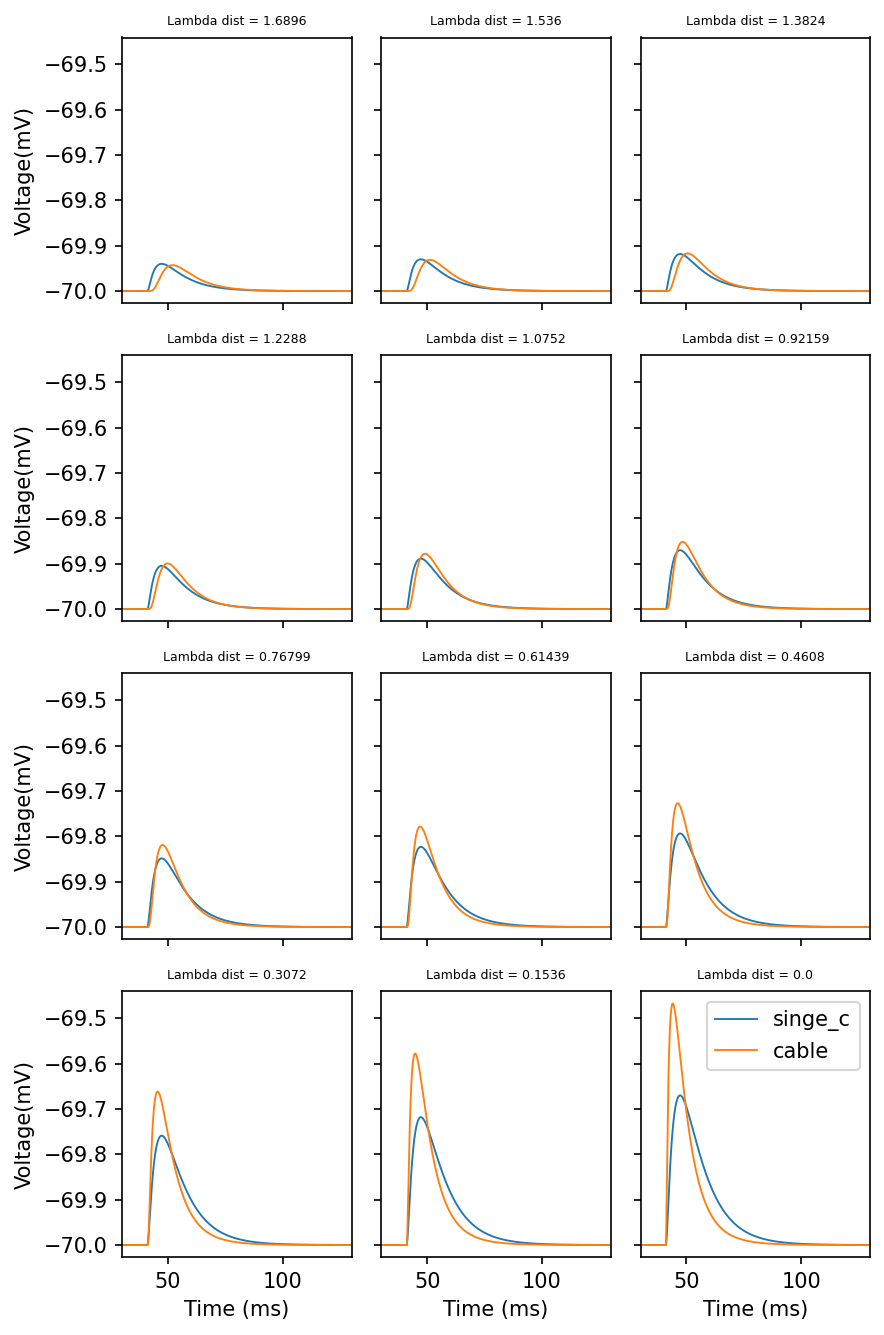

In [42]:
rtime = 0.5 #ms
dtime = 3.5 #ms
#rtime=0.0001#0.3
#dtime=9e9#10

for syn in synape_per_x.values():
    syn.tau1 = rtime
    syn.tau2 = dtime
    
for syn in dend_synapses:
    syn.tau1 = rtime
    syn.tau2 = dtime

for i in ncon_per_x.values(): i.weight[0]=0
for ncon_dend in dend_ncons: ncon_dend.weight[0] =0

_,axes = subplots(4,3,sharex=True, sharey=True,figsize = (6,9),dpi=150)
axes = axes.flatten()

for i,ncon_dend in enumerate(tqdm(dend_ncons[39:51][:12])):
    ncon_dend.weight[0] = syn_cond*10**-3
    ncon_per_x[ncon_dend.syn().get_segment().x].weight[0] = syn_cond*10**-3
    h.run()
    
    ncon_dend.weight[0] = 0
    ncon_per_x[ncon_dend.syn().get_segment().x].weight[0] = 0
    plt.sca(axes[i])
    plot(tvec,singe_vv,label='singe_c', lw=0.9)
    plot(tvec,vvec, label='cable', lw=0.9)
    title(f"Lambda dist = {df.query(f'seg_x=={ncon_dend.syn().get_segment().x}').dist_per_syn.values[0]/lmda:.5}",fontsize=6)

    if i%3==0:
        ylabel('Voltage(mV)')
    if i>8:
        xlabel("Time (ms)")
xlim(30,130)
tight_layout()
legend()
